In [5]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import time
from nltk.corpus import wordnet
import random
from optuna import create_study, trial
from sklearn.model_selection import KFold

# CSV 파일 로드
print("CSV 파일 로드 중...")
df = pd.read_csv('data_2\year5_2.csv', encoding='cp949')
print(f"데이터 로드 완료. 샘플 수: {len(df)}")

# '발화문'과 '1번 감정'만 사용
X = df['발화문']
y = df['1번 감정']

# 레이블 인코딩
print("레이블 인코딩 중...")
le = LabelEncoder()
y = le.fit_transform(y)
print(f"고유 감정 레이블 수: {len(le.classes_)}")

# 마침표와 쉼표를 제거하는 함수 정의
def remove_punctuation(text):
    return text.replace('.', '').replace(',', '')

# 'text' 열에 함수 적용
X = X.apply(remove_punctuation)

print(X)

# 불용어 목록 정의
stopwords = set([
    '는', '은', '이', '가', '을', '를', '에', '의', '도', '에서', '와', '과', '로', '으로',
    '그리고', '그러나', '그런데', '하지만', '또는', '그래서', '따라서',
    '이것', '저것', '그것', '우리', '여러분', '나', '너', '그', '그녀',
    '입니다', '있습니다', '합니다', '되었습니다', '있다', '것이다', '합니다'
])

# 불용어 제거 함수 정의
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        meaningful_words = [word for word in words if word not in stopwords]
        return ' '.join(meaningful_words)
    return text

# 'text' 열에 함수 적용
X = X.apply(remove_punctuation)

print(X)


# 데이터 분할
print("데이터 분할 중...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"학습 데이터 수: {len(X_train)}, 테스트 데이터 수: {len(X_test)}")

# KLUE/BERT 모델 및 토크나이저 로드
print("KLUE/BERT 모델 및 토크나이저 로드 중...")
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# GPU 사용 가능 시 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)
print(f"모델 로드 완료. 사용 중인 디바이스: {device}")


# 데이터 토큰화 및 모델 입력 준비 함수
def tokenize_data(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# PyTorch 텐서를 numpy 배열로 변환하는 함수
def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

# BERT 임베딩을 생성하는 함수 (배치 처리)
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 생성 중"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# 학습 및 테스트 데이터에 대한 BERT 임베딩 생성
print("학습 데이터 임베딩 생성 중...")
start_time = time.time()
X_train_emb = get_embeddings(X_train.tolist())
print(f"학습 데이터 임베딩 생성 완료. 소요 시간: {time.time() - start_time:.2f}초")

print("테스트 데이터 임베딩 생성 중...")
start_time = time.time()
X_test_emb = get_embeddings(X_test.tolist())
print(f"테스트 데이터 임베딩 생성 완료. 소요 시간: {time.time() - start_time:.2f}초")


CSV 파일 로드 중...
데이터 로드 완료. 샘플 수: 19374
레이블 인코딩 중...
고유 감정 레이블 수: 7
데이터 분할 중...
학습 데이터 수: 15499, 테스트 데이터 수: 3875
KLUE/BERT 모델 및 토크나이저 로드 중...


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


모델 로드 완료. 사용 중인 디바이스: cuda
학습 데이터 임베딩 생성 중...


임베딩 생성 중: 100%|██████████| 485/485 [00:21<00:00, 22.91it/s]


학습 데이터 임베딩 생성 완료. 소요 시간: 21.18초
테스트 데이터 임베딩 생성 중...


임베딩 생성 중: 100%|██████████| 122/122 [00:04<00:00, 24.84it/s]

테스트 데이터 임베딩 생성 완료. 소요 시간: 4.92초


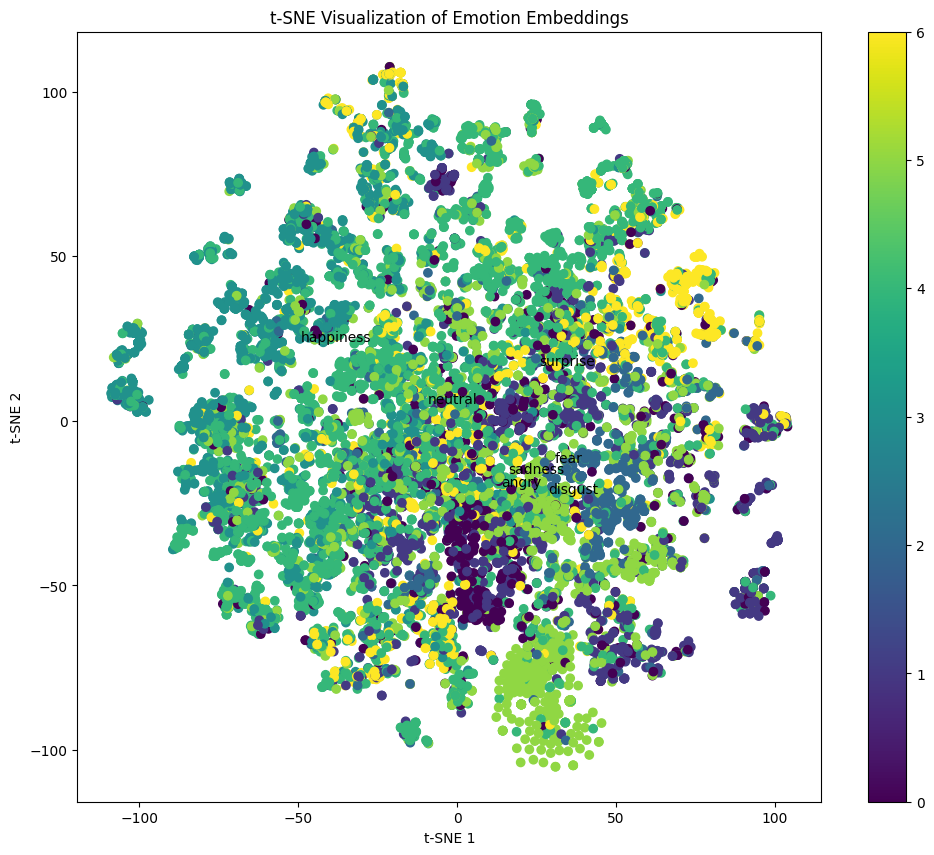

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_emb)

# 결과 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Emotion Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# 레이블 추가
for i, emotion in enumerate(le.classes_):
    plt.annotate(emotion, (X_tsne[y_train == i, 0].mean(), X_tsne[y_train == i, 1].mean()))

plt.show()

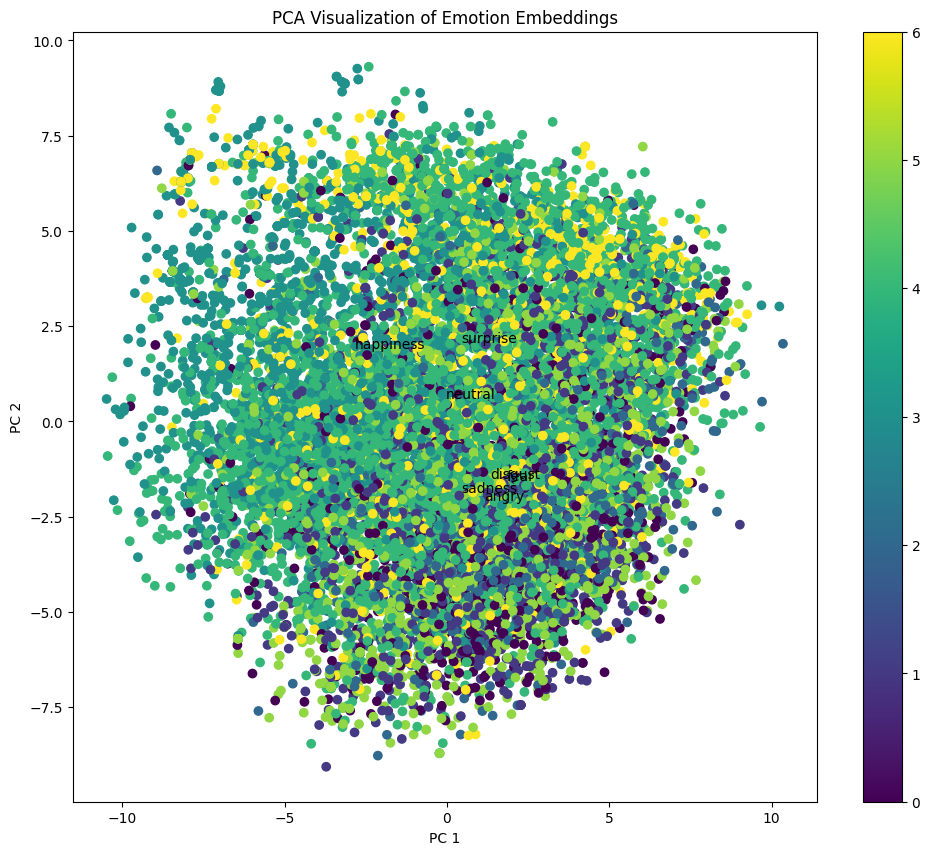

In [11]:
from sklearn.decomposition import PCA

# PCA 모델 생성 및 학습
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_emb)

# 결과 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.colorbar(scatter)
plt.title('PCA Visualization of Emotion Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# 레이블 추가
for i, emotion in enumerate(le.classes_):
    plt.annotate(emotion, (X_pca[y_train == i, 0].mean(), X_pca[y_train == i, 1].mean()))

plt.show()

In [8]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


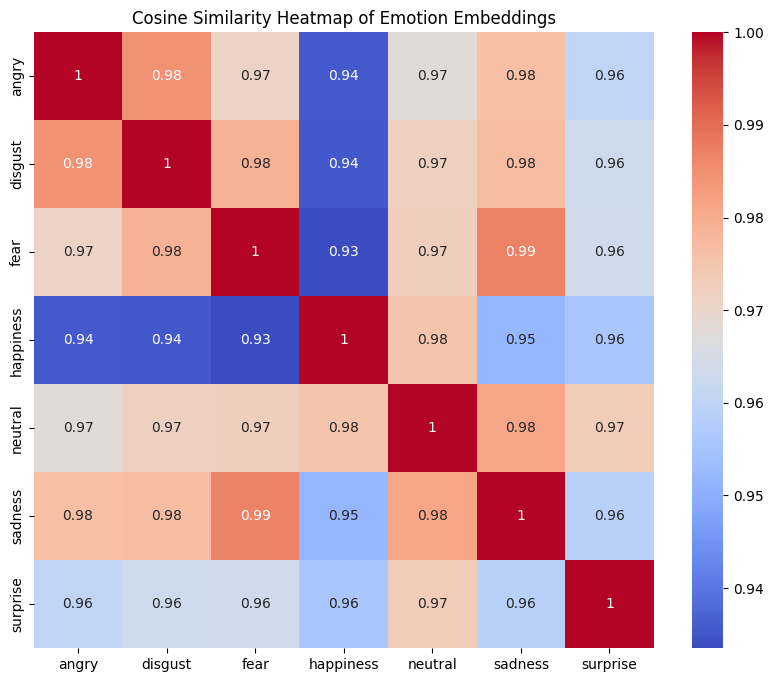

In [9]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# 각 감정 클래스의 평균 임베딩 계산
emotion_embeddings = []
for i in range(len(le.classes_)):
    emotion_embeddings.append(X_train_emb[y_train == i].mean(axis=0))

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(emotion_embeddings)

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Cosine Similarity Heatmap of Emotion Embeddings')
plt.show()

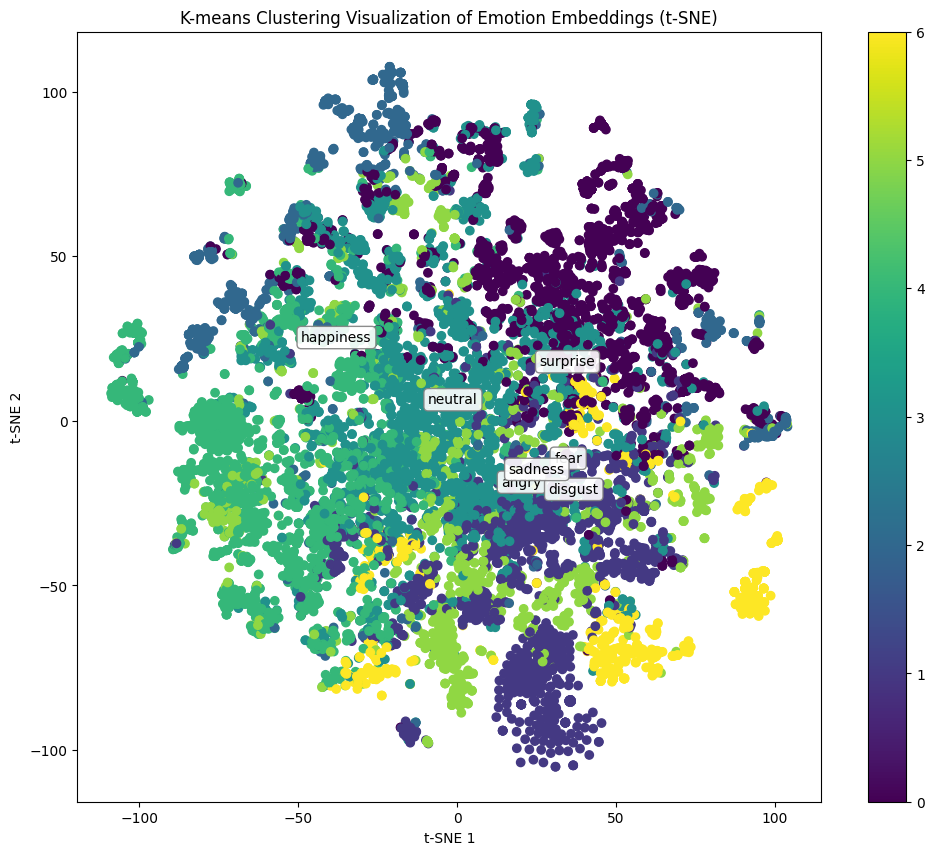

In [10]:
from sklearn.cluster import KMeans

# K-means 클러스터링
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42)
cluster_labels = kmeans.fit_predict(X_train_emb)

# t-SNE로 차원 축소
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train_emb)

# 결과 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering Visualization of Emotion Embeddings (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# 실제 레이블 추가
for i, emotion in enumerate(le.classes_):
    plt.annotate(emotion, (X_tsne[y_train == i, 0].mean(), X_tsne[y_train == i, 1].mean()), 
                 bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))

plt.show()

In [13]:
pip install plotly

   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ------------------- -------------------- 8.7/17.3 MB 44.6 MB/s eta 0:00:01
   ---------------------------------------  17.3/17.3 MB 51.9 MB/s eta 0:00:01
   ---------------------------------------- 17.3/17.3 MB 35.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import plotly.express as px
from sklearn.manifold import TSNE

# 3차원 t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_train_emb)

# 데이터프레임 생성
df = pd.DataFrame({
    'tsne-3d-1': X_tsne_3d[:,0],
    'tsne-3d-2': X_tsne_3d[:,1],
    'tsne-3d-3': X_tsne_3d[:,2],
    'emotion': [le.classes_[i] for i in y_train],
    'text': X_train.tolist()
})

# 3D 산점도 생성
fig = px.scatter_3d(df, x='tsne-3d-1', y='tsne-3d-2', z='tsne-3d-3',
                    color='emotion', hover_data=['text'], labels={'color': 'emotion'})
fig.update_layout(title='3D t-SNE of Emotion Embeddings')
fig.show()

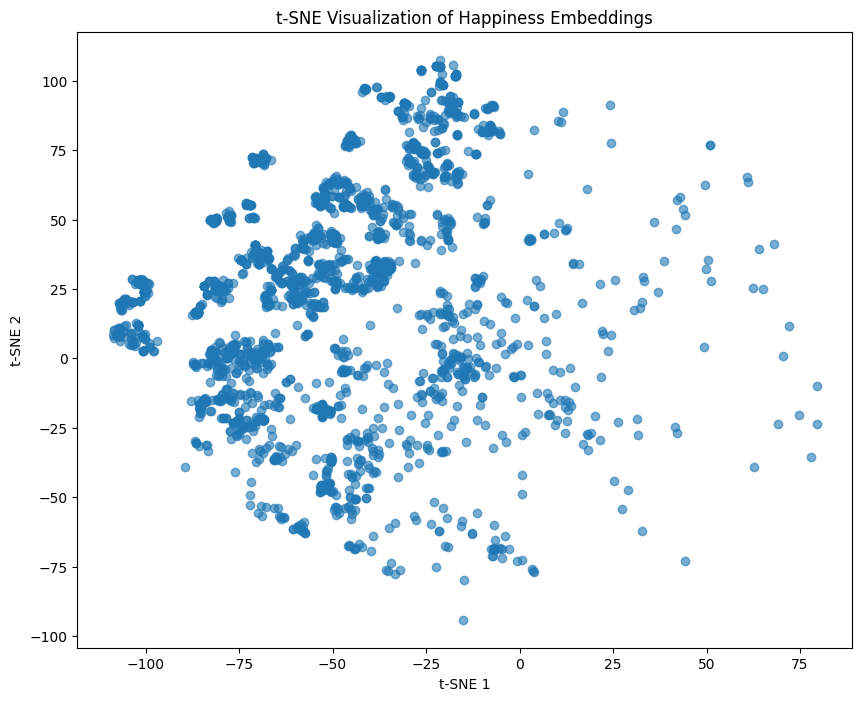

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 2차원 t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_emb)

# 시각화할 클래스 선택 (예: 'happiness')
selected_class = 'happiness'
class_index = list(le.classes_).index(selected_class)

# 선택된 클래스의 데이터 포인트만 필터링
mask = y_train == class_index
X_tsne_filtered = X_tsne[mask]

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_filtered[:, 0], X_tsne_filtered[:, 1], alpha=0.6)
plt.title(f't-SNE Visualization of {selected_class.capitalize()} Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

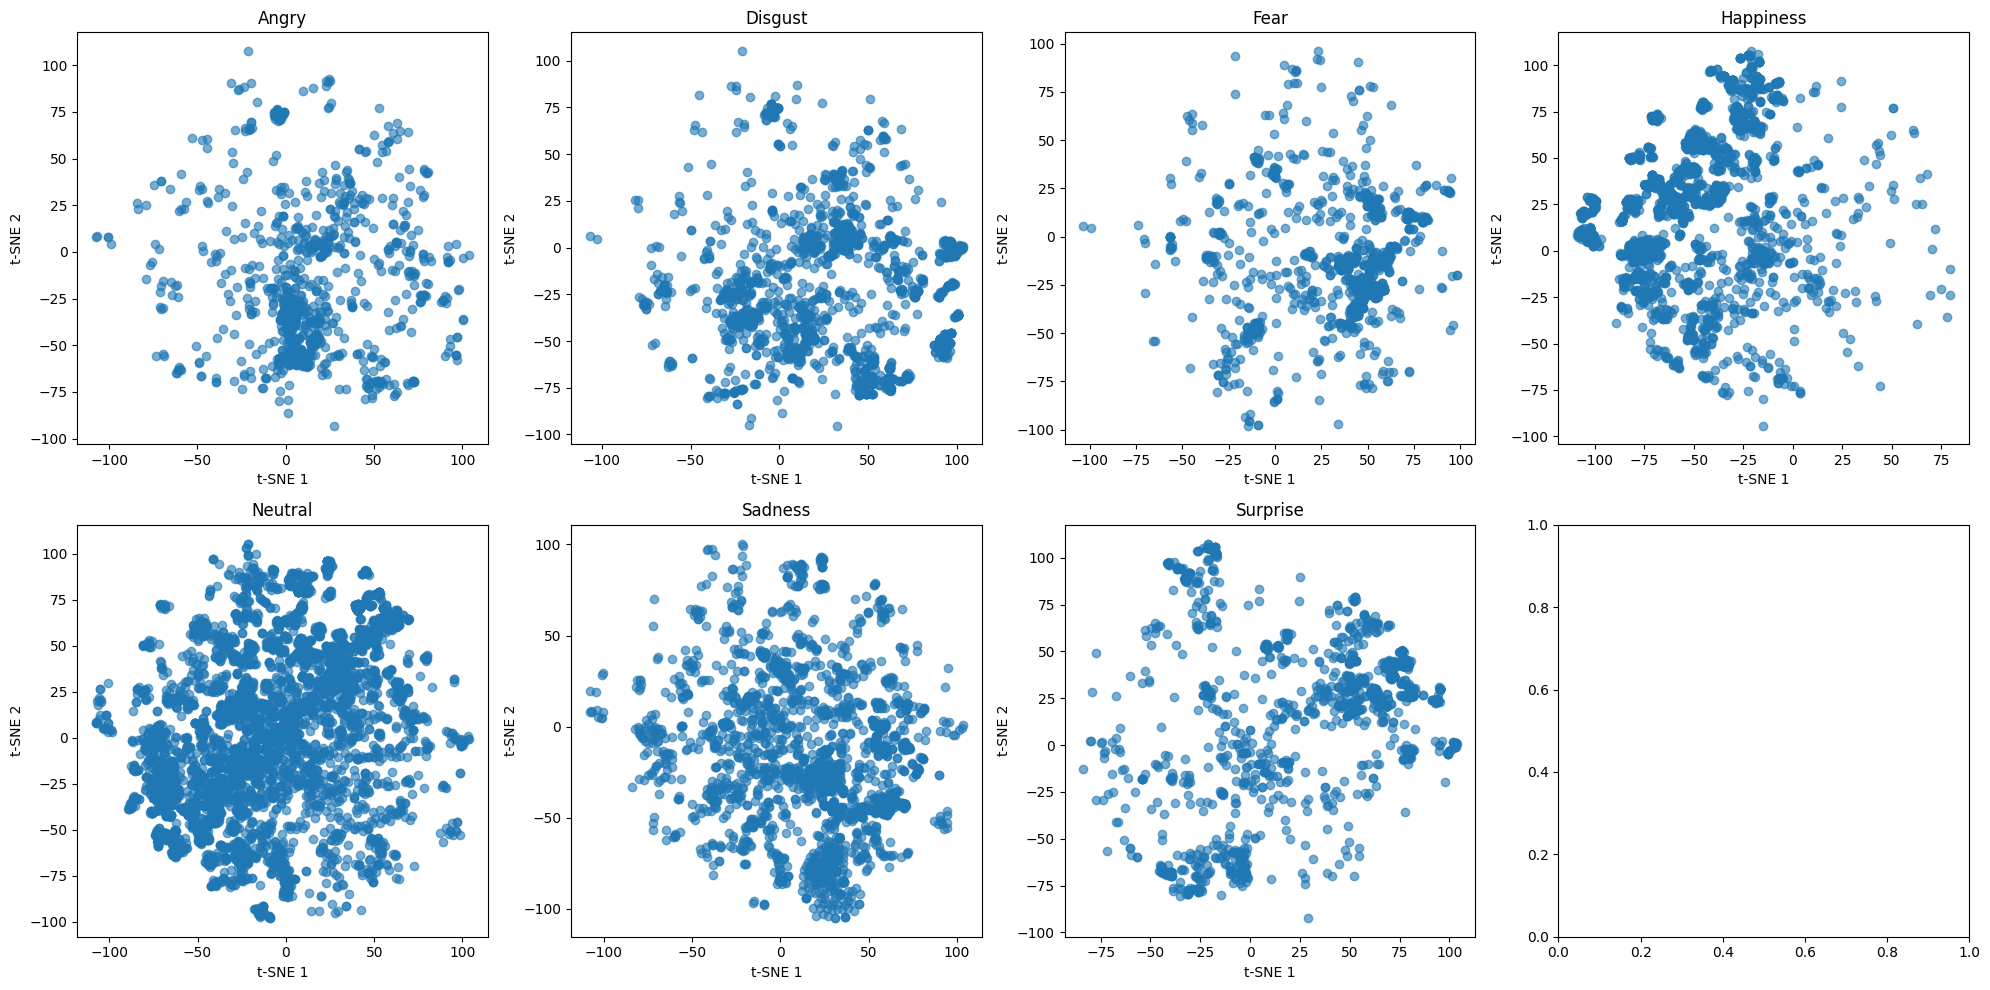

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 2차원 t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_emb)

# 서브플롯 생성
n_classes = len(le.classes_)
fig, axes = plt.subplots(2, (n_classes + 1) // 2, figsize=(20, 10))
axes = axes.flatten()

for i, emotion in enumerate(le.classes_):
    mask = y_train == i
    ax = axes[i]
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], alpha=0.6)
    ax.set_title(f'{emotion.capitalize()}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [15]:
# 데이터 증강 함수
def augment_text(text):
    words = text.split()
    augmented = []
    for word in words:
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        if len(synonyms) > 0:
            augmented.append(random.choice(synonyms))
        else:
            augmented.append(word)
    return " ".join(augmented)

# 데이터 증강
print("데이터 증강 중...")
augmented_X = [augment_text(text) for text in X]
X = pd.concat([X, pd.Series(augmented_X)])
y = pd.concat([y, y])

# 레이블 인코딩
le = LabelEncoder()
y = le.fit_transform(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# BERT 모델 및 토크나이저 로드
print("BERT 모델 로드 중...")
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

데이터 증강 중...
BERT 모델 로드 중...


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# 임베딩 생성 함수
def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 생성 중"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# 임베딩 생성
X_train_emb = get_embeddings(X_train.tolist())
X_test_emb = get_embeddings(X_test.tolist())


# Optuna를 사용한 하이퍼파라미터 최적화
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(768,)))
    for units in n_units:
        model.add(keras.layers.Dense(units, activation='gelu'))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(len(le.classes_), activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model





def create_model(params):
    if isinstance(params, dict):
        # 딕셔너리에서 직접 값을 가져옵니다
        n_layers = params['n_layers']
        n_units = [params[f'n_units_l{i}'] for i in range(n_layers)]
        dropout_rate = params['dropout_rate']
        learning_rate = params['learning_rate']
    else:
        # Optuna Trial 객체로 간주하고 suggest 메서드를 사용합니다
        n_layers = params.suggest_int('n_layers', 1, 3)
        n_units = [params.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
        dropout_rate = params.suggest_uniform('dropout_rate', 0.1, 0.5)
        learning_rate = params.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(768,)))
    for units in n_units:
        model.add(keras.layers.Dense(units, activation='gelu'))
        model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(len(le.classes_), activation='softmax'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 최적의 하이퍼파라미터로 모델 생성
best_model = create_model(study.best_params)

# 사용자 정의 콜백 클래스 생성
class ProgressCallback(keras.callbacks.Callback):
    def __init__(self, epochs):
        super(ProgressCallback, self).__init__()
        self.epochs = epochs
        self.progbar = None

    def on_train_begin(self, logs=None):
        print("학습 시작...")
        self.progbar = tqdm(total=self.epochs, desc="Epochs")

    def on_epoch_end(self, epoch, logs=None):
        self.progbar.update(1)
        self.progbar.set_postfix(loss=f"{logs['loss']:.4f}", accuracy=f"{logs['accuracy']:.4f}", 
                                 val_loss=f"{logs['val_loss']:.4f}", val_accuracy=f"{logs['val_accuracy']:.4f}")

    def on_train_end(self, logs=None):
        self.progbar.close()
        print("학습 완료!")


# Optuna 목적 함수 수정
def objective(trial):
    model = create_model(trial)
    epochs = 20
    progress_callback = ProgressCallback(epochs)
    history = model.fit(X_train_emb, y_train, 
                        validation_split=0.2,
                        epochs=epochs, 
                        batch_size=32,
                        callbacks=[keras.callbacks.EarlyStopping(patience=3), progress_callback],
                        verbose=0)
    return history.history['val_accuracy'][-1]

# Optuna 연구 생성 및 실행
study = create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# 최적의 하이퍼파라미터로 모델 생성
best_params = study.best_params
best_model = create_model(best_params)

임베딩 생성 중: 100%|██████████| 243/243 [00:09<00:00, 24.60it/s]
[I 2024-08-05 16:40:56,649] A new study created in memory with name: no-name-42450a60-b97f-4367-9ec1-c4618646c301
C:\Users\Hope\AppData\Local\Temp\ipykernel_4424\3507565328.py:53: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = params.suggest_uniform('dropout_rate', 0.1, 0.5)
C:\Users\Hope\AppData\Local\Temp\ipykernel_4424\3507565328.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = params.suggest_loguniform('learning_rate', 1e-5, 1e-2)


학습 시작...


Epochs:  20%|██        | 4/20 [00:14<00:58,  3.63s/it, accuracy=0.5974, loss=1.1393, val_accuracy=0.5982, val_loss=1.1094]